## 프로젝트 : 네이버 영화리뷰 감성분석 도전하기
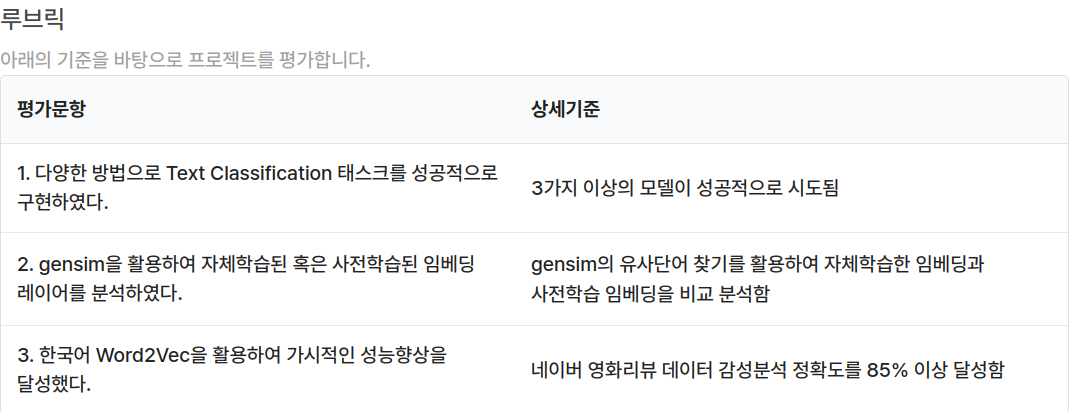

### 라이브러리 버전 확인

In [16]:
import gensim
import pandas as pd
import numpy as np
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
import os
import konlpy
from konlpy.tag import Okt
from konlpy.tag import Mecab
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

print(pd.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


### 1. 데이터 준비와 확인

In [17]:
# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head(20)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
5,5403919,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,0
6,7797314,원작의 긴장감을 제대로 살려내지못했다.,0
7,9443947,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...,0
8,7156791,액션이 없는데도 재미 있는 몇안되는 영화,1
9,5912145,왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?,1


긍정은 1, 부정은 0으로 나타나 있는데, 몇몇 댓글은 레이블 자체가 잘못 분류되어있다.  

### 2. 데이터로더 구성

In [18]:
# 이걸 어떻게 본인이 짜지?

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any')
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(X_train), len(y_test)))

훈련 샘플 개수: 146182, 테스트 개수: 49157


In [19]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [20]:
# 단어 사전 일부 출력 
from itertools import islice

dict(islice(index_to_word.items(), 20))

{0: '<PAD>',
 1: '<BOS>',
 2: '<UNK>',
 3: '<UNUSED>',
 4: '.',
 5: '영화',
 6: '다',
 7: '고',
 8: '하',
 9: '을',
 10: '보',
 11: '..',
 12: '게',
 13: ',',
 14: '!',
 15: '지',
 16: '있',
 17: '없',
 18: '?',
 19: '좋'}

Ref. 
https://domdom.tistory.com/84 islice 이용해 딕셔너리 자료형 일부만 보기 

In [21]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [22]:
# 첫 번째 리뷰 출력 
print(get_decoded_sentence(X_train[0], index_to_word))

더 빙 . . 진짜 짜증 나 네요 목소리


### 3. 모델 구성을 위한 데이터 분석 및 가공

In [23]:
# 리뷰 예시 확인 
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


In [24]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092


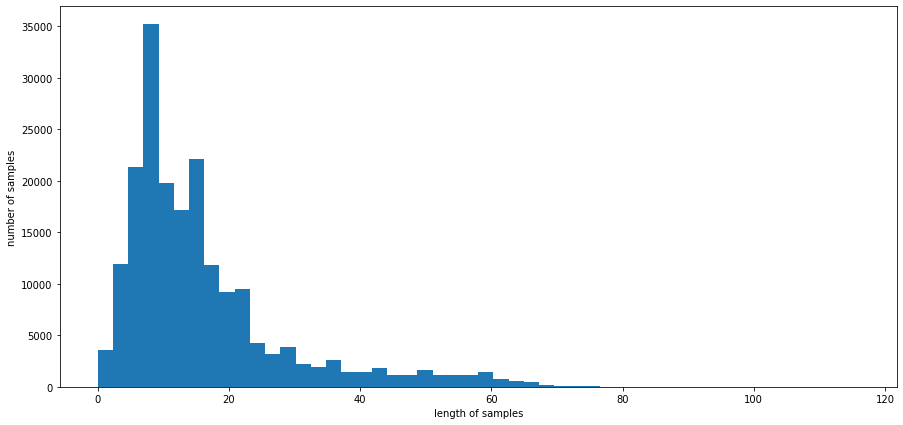

In [25]:
# 문장 길이의 분포 
plt.figure(figsize = (15, 7))

plt.hist([len(tokens) for tokens in total_data_text], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

Ref.   
https://wikidocs.net/50739 문장길이 히스토그램으로 나타내기 

In [26]:
# 최대 문장 길이 지정 : (평균 + 2*표준편차)
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(round(np.sum(num_tokens < max_tokens) / len(num_tokens)*100, 2) ))

pad_sequences maxlen :  41
전체 문장의 93.43%가 maxlen 설정값 이내에 포함됩니다. 


In [27]:
# padding 추가
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', 
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', 
                                                       maxlen=maxlen)

print(X_train.shape)  
print(X_test.shape) 

(146182, 41)
(49157, 41)


In [28]:
# 문장길이의 평균값, 최대값, 표준편차를 다시 계산해본다.
total_data_text = list(X_train) + list(X_test)

# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  41.0
문장길이 최대 :  41
문장길이 표준편차 :  0.0


### 4. 모델 구성 및 validation set 구성
모델은 3가지 이상 다양하게 구성하여 실험해 보세요.

In [29]:
vocab_size = len(word_to_index)  # 어휘 사전의 크기: 10000개 단어
word_vector_dim = 200   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. (변경 가능한 하이퍼 파라미터)

#### 1) 모델 1 : RNN - LSTM

In [30]:
# 모델 1: RNN 

model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_lstm.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model_lstm.add(tf.keras.layers.Dense(8, activation='relu'))
model_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 200)         2000000   
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 6688      
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________


#### 2) 모델 2 : 1-D CNN

In [31]:
# 모델 2: 1-D CNN

model_1d_cnn = tf.keras.Sequential()
model_1d_cnn.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_1d_cnn.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_1d_cnn.add(tf.keras.layers.MaxPooling1D(5))
model_1d_cnn.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_1d_cnn.add(tf.keras.layers.GlobalMaxPooling1D())
model_1d_cnn.add(tf.keras.layers.Dense(8, activation='relu'))
model_1d_cnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_1d_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          22416     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

#### 3) 모델 3 : GlobalMaxPooling1D() 레이어 1개만 사용

In [32]:
# 모델 3: GlobalMaxPooling1D() 레이어 1개만 사용

model_gmp1d = tf.keras.Sequential()
model_gmp1d.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_gmp1d.add(tf.keras.layers.GlobalMaxPooling1D())
model_gmp1d.add(tf.keras.layers.Dense(8, activation='relu'))
model_gmp1d.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_gmp1d.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 1608      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 2,001,617
Trainable params: 2,001,617
Non-trainable params: 0
_________________________________________________________________


### 5. 모델 훈련 개시

In [33]:
# 검증 데이터 분리 
x_val_len = int(len(X_train)*0.2)
y_val_len = int(len(y_train)*0.2)

x_val = X_train[:x_val_len]   
y_val = y_train[:y_val_len]

print('x_val : ', x_val.shape)  # (29236, 41)
print('y_val : ', y_val.shape)  # (29236,)

partial_x_train = X_train[x_val_len:]  
partial_y_train = y_train[y_val_len:]

print('x_train : ', partial_x_train.shape)  # (116946, 41)
print('y_train : ', partial_y_train.shape)  # (116946,)

x_val :  (29236, 41)
y_val :  (29236,)
x_train :  (116946, 41)
y_train :  (116946,)


In [34]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

#### 1) 모델 1 : RNN - LSTM

In [35]:
model_lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_lstm = model_lstm.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[early_stopping])

Epoch 1/20
229/229 [==============================] - 5s 9ms/step - loss: 0.4651 - accuracy: 0.7958 - val_loss: 0.3549 - val_accuracy: 0.8508
Epoch 2/20
229/229 [==============================] - 2s 7ms/step - loss: 0.3265 - accuracy: 0.8639 - val_loss: 0.3382 - val_accuracy: 0.8546
Epoch 3/20
229/229 [==============================] - 2s 8ms/step - loss: 0.2951 - accuracy: 0.8774 - val_loss: 0.3378 - val_accuracy: 0.8555
Epoch 4/20
229/229 [==============================] - 2s 7ms/step - loss: 0.2698 - accuracy: 0.8883 - val_loss: 0.3383 - val_accuracy: 0.8567
Epoch 5/20
229/229 [==============================] - 2s 7ms/step - loss: 0.2453 - accuracy: 0.8992 - val_loss: 0.3420 - val_accuracy: 0.8579
Epoch 6/20
229/229 [==============================] - 2s 7ms/step - loss: 0.2218 - accuracy: 0.9105 - val_loss: 0.3573 - val_accuracy: 0.8553
Epoch 7/20
229/229 [==============================] - 2s 7ms/step - loss: 0.2020 - accuracy: 0.9186 - val_loss: 0.3838 - val_accuracy: 0.8511
Epoch 

In [36]:
# 모델 평가
results_lstm = model_lstm.evaluate(X_test,  y_test, verbose=2)  # (loss, accuracy)

print(results_lstm)  

1537/1537 - 3s - loss: 0.4103 - accuracy: 0.8482
[0.41026929020881653, 0.8482210040092468]


#### 2) 모델 2 : 1-D CNN

In [37]:
model_1d_cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_1d_cnn = model_1d_cnn.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[early_stopping])

Epoch 1/20
229/229 [==============================] - 4s 8ms/step - loss: 0.4335 - accuracy: 0.7993 - val_loss: 0.3417 - val_accuracy: 0.8496
Epoch 2/20
229/229 [==============================] - 2s 7ms/step - loss: 0.2997 - accuracy: 0.8738 - val_loss: 0.3255 - val_accuracy: 0.8613
Epoch 3/20
229/229 [==============================] - 2s 7ms/step - loss: 0.2377 - accuracy: 0.9061 - val_loss: 0.3345 - val_accuracy: 0.8600
Epoch 4/20
229/229 [==============================] - 2s 7ms/step - loss: 0.1659 - accuracy: 0.9397 - val_loss: 0.3800 - val_accuracy: 0.8514
Epoch 5/20
229/229 [==============================] - 2s 7ms/step - loss: 0.1037 - accuracy: 0.9658 - val_loss: 0.4497 - val_accuracy: 0.8482
Epoch 6/20
229/229 [==============================] - 2s 7ms/step - loss: 0.0652 - accuracy: 0.9794 - val_loss: 0.5304 - val_accuracy: 0.8460
Epoch 7/20
229/229 [==============================] - 2s 7ms/step - loss: 0.0435 - accuracy: 0.9870 - val_loss: 0.6019 - val_accuracy: 0.8438
Epoch 

In [38]:
# 모델 평가
results_1d_cnn = model_1d_cnn.evaluate(X_test,  y_test, verbose=2)  # (loss, accuracy)

print(results_1d_cnn)     

1537/1537 - 3s - loss: 0.6326 - accuracy: 0.8381
[0.6326485872268677, 0.8381105661392212]


#### 3) 모델 3 : GlobalMaxPooling1D() 레이어 1개만 사용

In [39]:
model_gmp1d.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_gmp1d = model_gmp1d.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[early_stopping])

Epoch 1/20
229/229 [==============================] - 2s 5ms/step - loss: 0.4795 - accuracy: 0.8017 - val_loss: 0.3486 - val_accuracy: 0.8466
Epoch 2/20
229/229 [==============================] - 1s 5ms/step - loss: 0.3157 - accuracy: 0.8659 - val_loss: 0.3325 - val_accuracy: 0.8559
Epoch 3/20
229/229 [==============================] - 1s 5ms/step - loss: 0.2681 - accuracy: 0.8909 - val_loss: 0.3361 - val_accuracy: 0.8566
Epoch 4/20
229/229 [==============================] - 1s 5ms/step - loss: 0.2277 - accuracy: 0.9105 - val_loss: 0.3495 - val_accuracy: 0.8566
Epoch 5/20
229/229 [==============================] - 1s 5ms/step - loss: 0.1882 - accuracy: 0.9301 - val_loss: 0.3702 - val_accuracy: 0.8561
Epoch 6/20
229/229 [==============================] - 1s 5ms/step - loss: 0.1478 - accuracy: 0.9491 - val_loss: 0.3995 - val_accuracy: 0.8537
Epoch 7/20
229/229 [==============================] - 1s 5ms/step - loss: 0.1093 - accuracy: 0.9659 - val_loss: 0.4375 - val_accuracy: 0.8509
Epoch 

In [40]:
# 모델 평가
results_gmp1d = model_gmp1d.evaluate(X_test,  y_test, verbose=2)  # (loss, accuracy)

print(results_gmp1d)  

1537/1537 - 2s - loss: 0.4507 - accuracy: 0.8435
[0.4507219195365906, 0.8435420989990234]


### 6. Loss, Accuracy 그래프 시각화

#### 1) 모델 1 : RNN - LSTM

In [41]:
history_dict = history_lstm.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [42]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

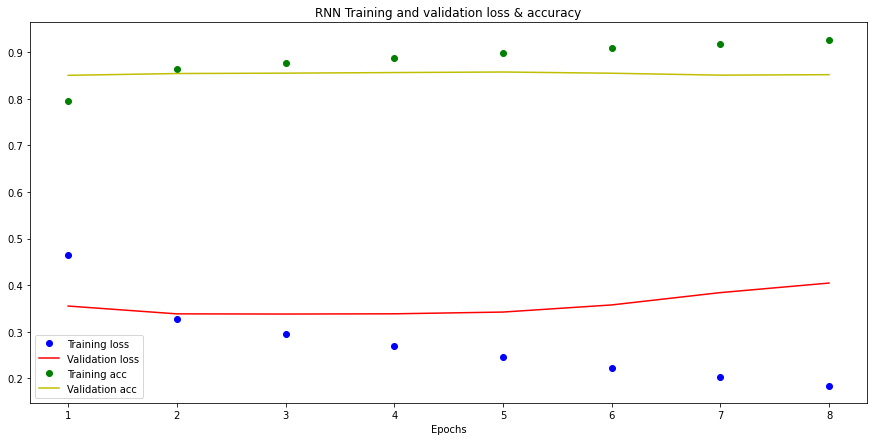

In [43]:
plt.figure(figsize = (15, 7))

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.plot(epochs, acc, 'go', label='Training acc')
plt.plot(epochs, val_acc, 'y', label='Validation acc')
plt.title('RNN Training and validation loss & accuracy')
plt.xlabel('Epochs')
plt.legend()

plt.show()  

#### 2) 모델 2 : 1-D CNN

In [44]:
history_dict = history_1d_cnn.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [45]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

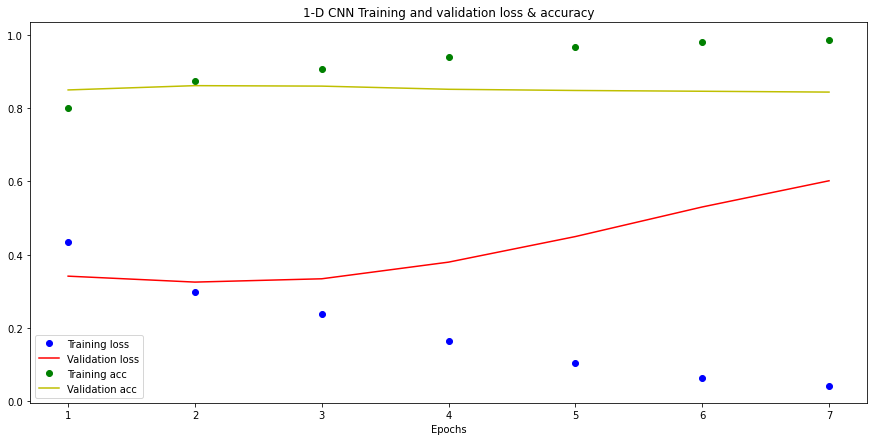

In [46]:
plt.figure(figsize = (15, 7))

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.plot(epochs, acc, 'go', label='Training acc')
plt.plot(epochs, val_acc, 'y', label='Validation acc')
plt.title('1-D CNN Training and validation loss & accuracy')
plt.xlabel('Epochs')
plt.legend()

plt.show()  

#### 3) 모델 3 : GlobalMaxPooling1D() 레이어 1개만 사용

In [47]:
history_dict = history_gmp1d.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [48]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

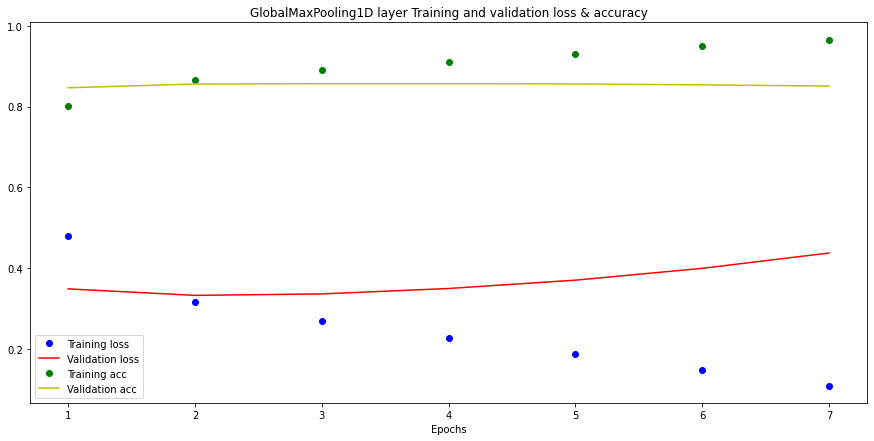

In [73]:
plt.figure(figsize = (15, 7))

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.plot(epochs, acc, 'go', label='Training acc')
plt.plot(epochs, val_acc, 'y', label='Validation acc')
plt.title('GlobalMaxPooling1D layer Training and validation loss & accuracy')
plt.xlabel('Epochs')
plt.legend()

plt.show()  

### 7. 학습된 Embedding 레이어 분석

In [50]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

#### 1) 모델 1 : RNN - LSTM

In [51]:
embedding_layer = model_lstm.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 200)


In [52]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_LSTM.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_lstm.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [53]:
# gensim에서 제공하는 패키지를 이용해, 위에 남긴 임베딩 파라미터를 읽어서 word vector로 활용
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['감동']
vector

array([ 0.04223406, -0.11655141,  0.1522849 ,  0.06721282,  0.15911855,
        0.12554373, -0.08059838, -0.15674728,  0.0700141 , -0.08903027,
        0.1127243 , -0.02793752, -0.16019525, -0.19348602, -0.08205255,
        0.06357791, -0.0308991 , -0.03702162, -0.07711285, -0.09807695,
        0.02541364,  0.09218177, -0.08153992,  0.07116762,  0.1303532 ,
        0.01827583, -0.01328977,  0.00836612,  0.06059522, -0.07935423,
        0.02219079, -0.11067673,  0.0100867 , -0.13027672,  0.02172393,
        0.04700847, -0.08090946,  0.06024591, -0.09889863,  0.13746256,
        0.01839013, -0.11118189, -0.04426287, -0.06686045, -0.12305155,
       -0.10478547,  0.11775266,  0.06269711,  0.01584558,  0.15897287,
       -0.07990255, -0.0219195 , -0.01161446, -0.0160808 ,  0.07878063,
        0.11849064,  0.06028957,  0.03349223, -0.11342987, -0.08700673,
        0.04692911, -0.05180961, -0.22367541,  0.12010139, -0.00591983,
        0.0034131 , -0.06652465, -0.11826903,  0.05783441, -0.08

In [54]:
# 워드 벡터가 의미 벡터 공간상에 유의미하게 학습되었는지 확인하기
# => 단어를 하나 주고 그와 가장 유사한 단어와 그 유사도를 확인하는 방법
word_vectors.similar_by_word("감동")  # 유사 단어와 유사도 확인

[('입감', 0.8532726168632507),
 ('다가오', 0.8459852933883667),
 ('전성기', 0.8321507573127747),
 ('명화', 0.8300036787986755),
 ('어울려요', 0.8298769593238831),
 ('짱', 0.8261950016021729),
 ('재미있', 0.8260911703109741),
 ('아름다운', 0.8208536505699158),
 ('乃', 0.8201544880867004),
 ('♥', 0.8198987245559692)]

In [55]:
word_vectors.similar_by_word("재미없") 

[('쓰레기', 0.9232155680656433),
 ('어설픈', 0.914483904838562),
 ('실망', 0.9134899377822876),
 ('잤', 0.9082311987876892),
 ('친일파', 0.9073324799537659),
 ('별로', 0.9066570401191711),
 ('짜증', 0.9009072780609131),
 ('낚였', 0.9006895422935486),
 ('오리엔탈리즘', 0.8974087238311768),
 ('수면제', 0.8944066762924194)]

In [56]:
word_vectors.similar_by_word("명작") 

[('수작', 0.9382297992706299),
 ('여운', 0.9302998781204224),
 ('진진', 0.9243724346160889),
 ('잼따', 0.9111608266830444),
 ('굳', 0.9109973907470703),
 ('굿', 0.9049132466316223),
 ('슬퍼요', 0.9036699533462524),
 ('완벽', 0.9024143218994141),
 ('고마워요', 0.9019438624382019),
 ('^.^', 0.9001932144165039)]

In [57]:
word_vectors.similar_by_word("끝장") 

[('완소', 0.915590226650238),
 ('싯', 0.9122457504272461),
 ('였음을', 0.9117960929870605),
 ('빨려', 0.9094221591949463),
 ('표한다', 0.9088382124900818),
 ('이영애', 0.9086836576461792),
 ('자격', 0.9086512923240662),
 ('애잔', 0.9076458215713501),
 ('졸이', 0.9074420928955078),
 ('맑', 0.9066239595413208)]

#### 2) 모델 2 : 1-D CNN

In [58]:
embedding_layer = model_1d_cnn.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 200)


In [59]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path =  os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_1-D_CNN.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_1d_cnn.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()     

In [60]:
# gensim에서 제공하는 패키지를 이용해, 위에 남긴 임베딩 파라미터를 읽어서 word vector로 활용
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['감동']
vector

array([ 0.07879423,  0.0880163 , -0.03836703,  0.03917105,  0.11082991,
        0.00463079, -0.00184514,  0.01830732, -0.01941663,  0.03328428,
        0.04520249, -0.08755706,  0.11733458,  0.00457888,  0.07383478,
        0.03220706, -0.009661  , -0.05594615,  0.03961978, -0.05589281,
        0.03324084,  0.02758151,  0.04040825,  0.04973428,  0.01982052,
       -0.03880076,  0.09781791, -0.03323976, -0.01340601,  0.03122302,
       -0.00211159, -0.04379621, -0.04951182,  0.11580813,  0.11460709,
        0.03094704, -0.08068387,  0.00243637, -0.10191559, -0.03970756,
       -0.05993947,  0.09281254, -0.04823533, -0.05415104,  0.02024478,
        0.00906468,  0.01208377, -0.00157599, -0.04011958,  0.05374858,
       -0.1331956 , -0.09932575, -0.0616684 , -0.00519958, -0.06064495,
        0.03866236, -0.04254935, -0.0260598 , -0.01878258,  0.03018507,
       -0.06711063,  0.04560583, -0.0039756 , -0.0363057 ,  0.00284559,
        0.00617314,  0.02561696, -0.06795361, -0.06263169, -0.06

In [61]:
# 워드 벡터가 의미 벡터 공간상에 유의미하게 학습되었는지 확인하기
# => 단어를 하나 주고 그와 가장 유사한 단어와 그 유사도를 확인하는 방법
word_vectors.similar_by_word("감동")  # 유사 단어와 유사도 확인

[('돋보였', 0.5865380764007568),
 ('먹먹', 0.577547013759613),
 ('로라', 0.5636069178581238),
 ('봣', 0.5393644571304321),
 ('싯', 0.5376474261283875),
 ('울림', 0.5359847545623779),
 ('돌파', 0.5352053642272949),
 ('지연', 0.5302305817604065),
 ('쉰', 0.529488742351532),
 ('we', 0.527269721031189)]

In [62]:
word_vectors.similar_by_word("재미없") 

[('그다지', 0.7446931004524231),
 ('엉성', 0.7327409386634827),
 ('문란', 0.7208496928215027),
 ('겉도', 0.7181479930877686),
 ('오그라들', 0.7144252061843872),
 ('다더니', 0.7131112813949585),
 ('원주율', 0.7115583419799805),
 ('강요', 0.7077723741531372),
 ('만드셨', 0.7058724164962769),
 ('단조', 0.7040418386459351)]

In [63]:
word_vectors.similar_by_word("명작") 

[('완소', 0.7713531255722046),
 ('진한', 0.7509009838104248),
 ('이제서야', 0.7424634099006653),
 ('슬퍼요', 0.7413150072097778),
 ('~~!!', 0.739822268486023),
 ('아름다워요', 0.7343170046806335),
 ('예뻐요', 0.7307581901550293),
 ('후딱', 0.722388505935669),
 ('서서히', 0.7209030389785767),
 ('희열', 0.7194595336914062)]

In [64]:
word_vectors.similar_by_word("끝장") 

[('-)', 0.8128077387809753),
 ('올려야', 0.8082793354988098),
 ('고마워요', 0.7970960140228271),
 ('♥♥♥', 0.7947044372558594),
 ('아름다워요', 0.7933478951454163),
 ('습니당', 0.791650652885437),
 ('乃', 0.7828059792518616),
 ('각지', 0.7801685929298401),
 ('^^~', 0.7789959907531738),
 ('그리움', 0.7784806489944458)]

#### 3) 모델 3 : GlobalMaxPooling1D() 레이어 1개만 사용

In [65]:
embedding_layer = model_gmp1d.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 200)


In [66]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_GlobalMaxPooling1D.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_gmp1d.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [67]:
# gensim에서 제공하는 패키지를 이용해, 위에 남긴 임베딩 파라미터를 읽어서 word vector로 활용
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['감동']
vector

array([-0.10133157, -0.05543866, -0.05627999, -0.11129676, -0.08077876,
       -0.0706534 ,  0.07517199, -0.06721402, -0.08458696, -0.10660464,
       -0.11415638, -0.06519791,  0.1047366 , -0.10354627, -0.08254591,
       -0.0800344 , -0.05826261, -0.09469625, -0.00199324, -0.02878975,
        0.10385002, -0.04563996, -0.0794431 , -0.11617491, -0.01369587,
       -0.09434924, -0.11905084,  0.13712357, -0.11955305, -0.07678401,
       -0.10416311, -0.10709783,  0.12916972, -0.10694098, -0.10313218,
       -0.082907  , -0.08547073, -0.04653717, -0.07268985, -0.07229383,
       -0.06091376,  0.06044418, -0.10553382,  0.00146766,  0.01956504,
        0.12810458, -0.00565415, -0.09180499,  0.14123361, -0.08118878,
       -0.12198119, -0.12351201, -0.10831485, -0.04724022, -0.08505114,
       -0.04232311, -0.07377078, -0.07539813, -0.08264128, -0.10078338,
        0.14001061, -0.0422043 , -0.11857399, -0.03758834, -0.08011021,
       -0.10683741, -0.10069607, -0.04352857, -0.09292895,  0.11

In [68]:
# 워드 벡터가 의미 벡터 공간상에 유의미하게 학습되었는지 확인하기
# => 단어를 하나 주고 그와 가장 유사한 단어와 그 유사도를 확인하는 방법
word_vectors.similar_by_word("감동")  # 유사 단어와 유사도 확인

[('음', 0.5611664652824402),
 ('반전', 0.5271816253662109),
 ('.', 0.5161566138267517),
 ('스러운', 0.5096405744552612),
 ('좋', 0.5093534588813782),
 ('주', 0.503605842590332),
 ('는데', 0.49659159779548645),
 ('영화', 0.49282121658325195),
 ('을', 0.48843222856521606),
 ('해', 0.48714661598205566)]

In [69]:
word_vectors.similar_by_word("재미없") 

[('걸린', 0.5201821327209473),
 ('진부', 0.4986174702644348),
 ('-_', 0.4937724471092224),
 ('평이', 0.48473307490348816),
 ('쓰레기', 0.48347267508506775),
 ('애매', 0.4793834984302521),
 ('번지르르', 0.45476314425468445),
 ('뻔해서', 0.4542335271835327),
 ('밋밋', 0.440263569355011),
 ('분장', 0.436808705329895)]

In [70]:
word_vectors.similar_by_word("명작") 

[('조아', 0.4452562928199768),
 ('씀', 0.40799039602279663),
 ('매우', 0.40462201833724976),
 ('마음', 0.4022687077522278),
 ('봐도', 0.39883753657341003),
 ('는데요', 0.387457937002182),
 ('색감', 0.38609579205513),
 ('언니', 0.38512179255485535),
 ('클래식', 0.38461044430732727),
 ('굉장히', 0.38438913226127625)]

In [71]:
word_vectors.similar_by_word("끝장") 

[('완소', 0.5595672130584717),
 ('잼따', 0.5467061400413513),
 ('흥미진진', 0.5335613489151001),
 ('great', 0.5323464274406433),
 ('테일러', 0.5323220491409302),
 ('치즈', 0.5322880148887634),
 ('눈물나', 0.5242184400558472),
 ('^^~', 0.5194448828697205),
 ('뜨거운', 0.516063392162323),
 ('설레', 0.5148349404335022)]

### 8. 한국어 Word2Vec 임베딩 활용하여 성능 개선
validation accuracy가 제일 높았던 RNN을 개선해보자!

In [84]:
from gensim.models import Word2Vec
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import KeyedVectors


word2vec_path = os.getenv('HOME')+'/data/word2vec_ko.model'

word2vec = gensim.models.Word2Vec.load(word2vec_path)

# 완성된 임베딩 매트릭스의 크기 확인
print(word2vec.wv.vectors.shape)     

(302960, 100)


In [87]:
vector = word2vec.wv.most_similar("감동")  # 메모리를 다소 많이 소비하는 작업이니 유의해 주세요.
vector     # 무려 300dim의 워드 벡터입니다.

[('감격', 0.8046045899391174),
 ('감탄', 0.7326707243919373),
 ('매혹', 0.7267226576805115),
 ('매력', 0.7088802456855774),
 ('감명', 0.7069407105445862),
 ('웃음', 0.7015025615692139),
 ('열정', 0.6936471462249756),
 ('칭찬', 0.6831857562065125),
 ('실망', 0.6779423952102661),
 ('슬픔', 0.6770600080490112)]

In [91]:
word2vec.wv.most_similar("재미없") 

[('멋있', 0.7958425283432007),
 ('재밌', 0.7673380970954895),
 ('어이없', 0.750990629196167),
 ('무섭', 0.7477750182151794),
 ('기쁘', 0.7310968637466431),
 ('재미있', 0.7225781083106995),
 ('서투르', 0.7222071290016174),
 ('지겹', 0.722015917301178),
 ('어설프', 0.7204605937004089),
 ('슬프', 0.720432698726654)]

In [92]:
word2vec.wv.most_similar("명작") 

[('걸작', 0.8363186717033386),
 ('대작', 0.780245840549469),
 ('거장', 0.7335883378982544),
 ('작품', 0.7322230339050293),
 ('명곡', 0.7084124684333801),
 ('그림책', 0.6971878409385681),
 ('창작물', 0.6824146509170532),
 ('희극', 0.673287570476532),
 ('인형극', 0.671007513999939),
 ('작품집', 0.6702387928962708)]

In [93]:
word2vec.wv.most_similar("끝장") 

[('결판', 0.6217898726463318),
 ('방금', 0.5827158689498901),
 ('산산조각', 0.5771081447601318),
 ('버텨', 0.5517261028289795),
 ('대박', 0.5434077382087708),
 ('한판', 0.5421271324157715),
 ('토해', 0.5310468673706055),
 ('견뎌', 0.5220803618431091),
 ('때려', 0.5177119970321655),
 ('밀쳐', 0.5165544748306274)]

In [111]:
vocab_size = len(word_to_index)    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec.wv:
        embedding_matrix[i] = word2vec.wv[index_to_word[i]]

In [113]:
from tensorflow.keras.initializers import Constant

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.LSTM(256))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. LSTM state 벡터의 차원수는 변경 가능
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               365568    
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 2056      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 1,367,633
Trainable params: 1,367,633
Non-trainable params: 0
_________________________________________________________________


In [114]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[early_stopping])

Epoch 1/20
229/229 [==============================] - 7s 25ms/step - loss: 0.4660 - accuracy: 0.7744 - val_loss: 0.3775 - val_accuracy: 0.8318
Epoch 2/20
229/229 [==============================] - 5s 23ms/step - loss: 0.3424 - accuracy: 0.8496 - val_loss: 0.3311 - val_accuracy: 0.8547
Epoch 3/20
229/229 [==============================] - 5s 23ms/step - loss: 0.2914 - accuracy: 0.8755 - val_loss: 0.3270 - val_accuracy: 0.8575
Epoch 4/20
229/229 [==============================] - 5s 23ms/step - loss: 0.2567 - accuracy: 0.8927 - val_loss: 0.3196 - val_accuracy: 0.8625
Epoch 5/20
229/229 [==============================] - 5s 23ms/step - loss: 0.2225 - accuracy: 0.9088 - val_loss: 0.3376 - val_accuracy: 0.8575
Epoch 6/20
229/229 [==============================] - 5s 23ms/step - loss: 0.1902 - accuracy: 0.9239 - val_loss: 0.3451 - val_accuracy: 0.8661
Epoch 7/20
229/229 [==============================] - 5s 24ms/step - loss: 0.1542 - accuracy: 0.9397 - val_loss: 0.3754 - val_accuracy: 0.8592

In [115]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results) 

1537/1537 - 4s - loss: 0.4796 - accuracy: 0.8541
[0.4795546233654022, 0.8540797829627991]


<mark>0.84던 val_accuracy가 0.85가 나왔다!!</mark>

In [116]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [117]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

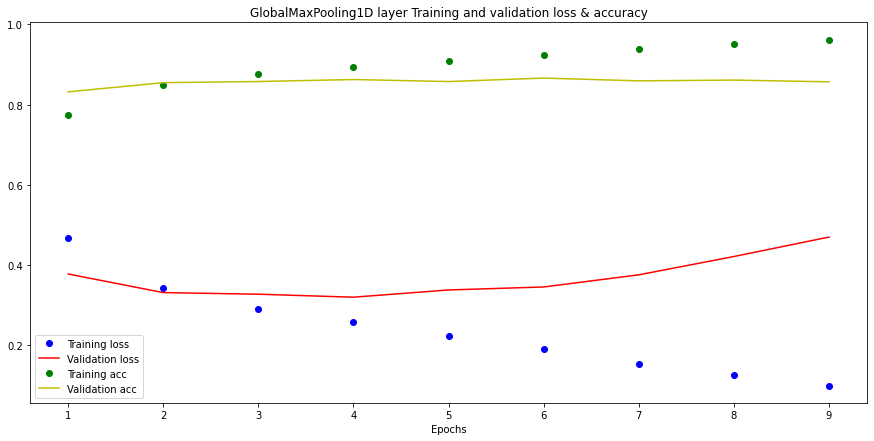

In [118]:
plt.figure(figsize = (15, 7))

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.plot(epochs, acc, 'go', label='Training acc')
plt.plot(epochs, val_acc, 'y', label='Validation acc')
plt.title('GlobalMaxPooling1D layer Training and validation loss & accuracy')
plt.xlabel('Epochs')
plt.legend()

plt.show()  

In [119]:
word_vectors.similar_by_word("감동")

[('음', 0.5611664652824402),
 ('반전', 0.5271816253662109),
 ('.', 0.5161566138267517),
 ('스러운', 0.5096405744552612),
 ('좋', 0.5093534588813782),
 ('주', 0.503605842590332),
 ('는데', 0.49659159779548645),
 ('영화', 0.49282121658325195),
 ('을', 0.48843222856521606),
 ('해', 0.48714661598205566)]

In [120]:
word_vectors.similar_by_word("재미없")

[('걸린', 0.5201821327209473),
 ('진부', 0.4986174702644348),
 ('-_', 0.4937724471092224),
 ('평이', 0.48473307490348816),
 ('쓰레기', 0.48347267508506775),
 ('애매', 0.4793834984302521),
 ('번지르르', 0.45476314425468445),
 ('뻔해서', 0.4542335271835327),
 ('밋밋', 0.440263569355011),
 ('분장', 0.436808705329895)]

In [121]:
word_vectors.similar_by_word("명작")

[('조아', 0.4452562928199768),
 ('씀', 0.40799039602279663),
 ('매우', 0.40462201833724976),
 ('마음', 0.4022687077522278),
 ('봐도', 0.39883753657341003),
 ('는데요', 0.387457937002182),
 ('색감', 0.38609579205513),
 ('언니', 0.38512179255485535),
 ('클래식', 0.38461044430732727),
 ('굉장히', 0.38438913226127625)]

In [122]:
word_vectors.similar_by_word("끝장")

[('완소', 0.5595672130584717),
 ('잼따', 0.5467061400413513),
 ('흥미진진', 0.5335613489151001),
 ('great', 0.5323464274406433),
 ('테일러', 0.5323220491409302),
 ('치즈', 0.5322880148887634),
 ('눈물나', 0.5242184400558472),
 ('^^~', 0.5194448828697205),
 ('뜨거운', 0.516063392162323),
 ('설레', 0.5148349404335022)]

## 회고
#### 이번 프로젝트는 감기 기운으로 몸이 좋지않아 아이펠 선배들의 깃허브를 많이 참고했다 .   
#### 직접 처음부터 끝까지 해내지 못해서 아쉬운 점이 많았다. 
Ref.    
https://github.com/HRPzz/AIFFEL

**헤맨 부분** 
- index_to_word, word_to_index 출력해보면, 0, 1, 2가 비어있어서, 직접 <PAD>, <BOS>, <UNK>로 지정해야하는건지 헤맸다. load_data 함수 설정 부분에 넣어줘야한다는걸 나중에 알았다. 
- 한국어 word2vec 불러올 때 계속 에러가 났다. KeyedVectors.load_word2vec_format()를 gensim.models.Word2Vec.load)로 바꾸니까 해결되었다. 

**문제를 해결하기 위한 시도와 원인 추론**
- step8에서 data 안에 word2vec_ko.model를 사용하라고 되어있는데, 나는 data 안에 해당 모델이 없어 한참 헤맸다. 알고보니 가장 상위 경로의 /data 안에서 찾았어야하는데, aiffel/sentiment_classification/data에서 찾아서 그런거였다. 
- embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피하는 부분에서 계속 TypeError: argument of type 'Word2Vec' is not iterable 에러가 났다. word2vec에 .wv를 붙이니 ValueError: could not broadcast input array from shape (100,) into shape (200,)에러가 났다. 디스코드에 질문했더니 수경님이 임베딩 레이어 쪽에 shape을 맞춰보라고 하셔서, word_vector_dim = 100으로 수정해 해결되었다!!
    
**새롭게 알게된 부분**
- 텍스트 데이터 처리에 대해, 저번 작곡가 프로젝트보다 심도 깊게 알게되었다. 
- RNN은 입력데이터가 순차 처리되어 padding시 pre가 post보다 효과적이다. 
- early stopping이 매우 효율적이다. 다음 모델 학습 프로젝트에도 꼭 활용해야겠다. 

**아직도 모르는 부분**
- 모델 성능을 더 올릴 방법
- 지영님이 추천한 케창딥 446p의 방법을 적용 못 해봤다. 